# BPR

In [1]:
import sys
import os
import cornac
import papermill as pm
import numpy as np
from functools import wraps
from tqdm.notebook import tqdm
import scrapbook as sb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from recommenders.evaluation.python_evaluation import get_top_k_items, map_at_k, ndcg_at_k, precision_at_k, recall_at_k, diversity, novelty, serendipity, distributional_coverage, catalog_coverage 
from recommenders.models.cornac.cornac_utils import predict,predict_ranking
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.utils.timer import Timer

print("System version: {}".format(sys.version))
print("Cornac version: {}".format(cornac.__version__))

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


/opt/anaconda3/envs/test/lib/python3.7/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


System version: 3.7.10 | packaged by conda-forge | (default, Oct 13 2021, 20:45:05) 
[Clang 11.1.0 ]
Cornac version: 1.14.1


In [2]:
#utils

# results table
cols = ["Data", "Algo", "K", "Train time (s)","Predicting time (s)", "RMSE", "MAE", "R2", "Explained Variance", "Recommending time (s)", "MAP", "nDCG@k", "Precision@k", "Recall@k","Diversity","Novelty","Distributional coverage","Catalog coverage"]
df_results = pd.DataFrame(columns=cols)

def generate_summary(data, algo, k, train_time, rating_time, rating_metrics, ranking_time, ranking_metrics, diversity_metrics):
    summary = {"Data": data, "Algo": algo, "K": k, "Train time (s)": train_time, "Predicting time (s)": rating_time, "Recommending time (s)":ranking_time}
    if rating_metrics is None:
        rating_metrics = {
            "RMSE": np.nan,
            "MAE": np.nan,
            "R2": np.nan,
            "Explained Variance": np.nan,
        }
    if ranking_metrics is None:
        ranking_metrics = {
            "MAP": np.nan,
            "nDCG@k": np.nan,
            "Precision@k": np.nan,
            "Recall@k": np.nan,
        }
    if diversity_metrics is None:
        diversity_metrics = {
        "Diversity": np.nan,
        "Novelty": np.nan,
        "Distributional coverage": np.nan,
        "Catalog coverage": np.nan,
    }
    summary.update(diversity_metrics)
    summary.update(rating_metrics)
    summary.update(ranking_metrics)

    return summary


def convert_timestamp(datetime):
    date_string = str(datetime)
    date = datetime.datetime.strptime(date_string, "%m/%d/%Y")
    timestamp = datetime.datetime.timestamp(date)
    return(timestamp)

def preprocess_data(df):
    # Convert the float precision to 32-bit in order to reduce memory consumption 
    df.loc[:, header["col_rating"]] = df[header["col_rating"]].astype(np.float32)
    df = df[[header["col_user"],header["col_item"],header["col_rating"]]]
    return df 

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        arg = args[0] if len(args)>=1 else "" 
        print('func:%r  took: %2.4f sec' % \
          (f.__name__, te-ts))
        return result
    return wrap

def predict_and_calculate_metrics(svd,test):
    predictions = predict(svd, test, usercol=header["col_user"], itemcol=header["col_item"])
    eval_rmse = rmse(test, predictions, 
                     col_user = header["col_user"],
                     col_item = header["col_item"],
                     col_rating = header["col_rating"],
                     col_prediction = header["col_prediction"]
                    )
    return(eval_rmse)
    

# 0. Config params

In [3]:
# table results 
algo = "bpr"
ranking_metrics = None
rating_metrics = None
diversity_metrics = None
train_time = np.nan
rating_time = np.nan
ranking_time = np.nan

# column name 
header = {
    "col_user": "customer_id",
    "col_item": "variant_id",
    "col_rating": "quantity",
    "col_timestamp": "order_date",
    "col_prediction": "prediction",
}

# top k
TOP_K = 10

################ TO MODIFY ################

# date size with 3 choices : "100k","1M" and "all"
data_size = "all"
# load splitted data 
load_splitted_data = True 

################ TO MODIFY ################

# 1. Data

# 1.1 Load data 

In [4]:
########### TO MODIFY ###########
def load_data(data_size):
    path = ""
    if data_size=="100k":
        path = '../../data/transaction_100k_df.pkl'
    elif data_size=="1M":
        path = '../../data/transaction_1M_df.pkl'
    elif data_size=="all":
        path = '../../data/transaction_all_df.pkl'
    
    if path != "":
        return pd.read_pickle(path)
    else :
        print("Please choose between 100k, 1M and all")
########### TO MODIFY ###########

In [5]:
# 2 ways to load the data
if not load_splitted_data : 
    # data not splitted 
    data = load_data(data_size)
else :
    # or  use stored splitted data to make it faster
    train = pd.read_pickle(f"../../data/train_{data_size}_df.pkl")
    test = pd.read_pickle(f"../../data/test_{data_size}_df.pkl")
    train.shape[0], test.shape[0]

## 1.2 Split the data ( skip if load_splitted_data )

In [6]:
# chrono split but it is really slow ( +1h to split 8M data ) 
if not load_splitted_data :
    train, test = python_chrono_split(data,
                                      ratio=0.75,
                                      col_user=header["col_user"],
                                      col_item=header["col_item"],
                                      col_timestamp = header["col_timestamp"]
                                     )
    train.to_pickle(f"../../data/train_{data_size}_df.pkl")
    test.to_pickle(f"../../data/test_{data_size}_df.pkl")
    train.shape[0], test.shape[0]

In [7]:
print("""
Train:
Total Ratings: {train_total}
Unique Users: {train_users}
Unique Items: {train_items}

Test:
Total Ratings: {test_total}
Unique Users: {test_users}
Unique Items: {test_items}
""".format(
    train_total=len(train),
    train_users=len(train[header["col_user"]].unique()),
    train_items=len(train[header["col_item"]].unique()),
    test_total=len(test),
    test_users=len(test[header["col_user"]].unique()),
    test_items=len(test[header["col_item"]].unique()),
))


Train:
Total Ratings: 6041296
Unique Users: 1497612
Unique Items: 7659

Test:
Total Ratings: 1799883
Unique Users: 869943
Unique Items: 7022



## 1.3 Process data

In [8]:
train = preprocess_data(train)
test = preprocess_data(test)

train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=42)

# 2. Model

In [9]:
bpr = cornac.models.BPR(
    k=500,
    max_iter=10,
    learning_rate=0.01,
    lambda_reg=0.01,
    verbose=True,
    seed=42
)

## 2.2 Train model

In [10]:
with Timer() as train_time:
     bpr.fit(train_set)

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization finished!


## 2.4  recommend k items

In [ ]:
top_k_list = []
train["group"] = train.groupby(header["col_user"]).ngroup()
max_group = max(train["group"])
with Timer() as ranking_time:
    for i in tqdm(range(0,max_group,1000)):
        train_subset = train[(train["group"]>=i) & (train["group"]<i+1000)]
        print(train_subset)
        top_all = predict_ranking(bpr, train_subset, usercol=header["col_user"], itemcol=header["col_item"], remove_seen=True)
        print(top_all)
        top_k_sample = get_top_k_items(top_all,col_user=header["col_user"], col_rating=header["col_prediction"],k=TOP_K)
        top_k_list.append(top_k_sample)
top_k=pd.concat(top_k_list)

  0%|          | 0/1498 [00:00<?, ?it/s]

     customer_id variant_id  quantity  group
0          00000     418795       1.0      0
1          00000     419496       1.0      0
2          00000     429174       2.0      0
4          00004     428665       6.0      1
10         00010     437410       2.0      2
...          ...        ...       ...    ...
3316       05028     428494       1.0    998
3322       05035     433730       1.0    999
3321       05035     433028       4.0    999
3320       05035     422992       1.0    999
3323       05035     434519       2.0    999

[2632 rows x 4 columns]


# 3. Evaluate

## 3.2 Ranking metrics 

In [ ]:
args = [test, top_k]

kwargs = dict(col_user = header["col_user"],
              col_item = header["col_item"],
              col_rating = header["col_rating"],
              col_prediction = header["col_prediction"],
              relevancy_method = 'top_k', 
              k = TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

ranking_metrics = {
    "MAP": eval_map,
    "nDCG@k": eval_ndcg,
    "Precision@k": eval_precision,
    "Recall@k": eval_recall
}

print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}",sep='\n')

## 3.3 Diversity metrics

In [ ]:
args = [train, top_k]

kwargs = dict(col_user = header["col_user"],
              col_item = header["col_item"],
             )

eval_diversity = diversity(*args, **kwargs)
eval_novelty = novelty(*args, **kwargs)
eval_distributional_coverage = distributional_coverage(*args, **kwargs)
eval_catalog_coverage = catalog_coverage(*args,**kwargs)

diversity_metrics = {
    "Diversity": eval_diversity,
    "Novelty": eval_novelty,
    "Distributional coverage": eval_distributional_coverage,
    "Catalog coverage": eval_catalog_coverage,
}

print(f"Model:",
      f"Diversity :\t\t\t {eval_diversity}",
      f"Novelty:\t\t\t {eval_novelty:f}",
      f"Catalog coverage:\t\t {eval_catalog_coverage:f}",
      f"Distributional coverage:\t {eval_distributional_coverage:f}",sep='\n')

##### 4 Summary

In [71]:
summary = generate_summary(data_size,
                           algo,
                           TOP_K,
                           train_time, 
                           rating_time,
                           rating_metrics,
                           ranking_time,
                           ranking_metrics,
                           diversity_metrics)
df_results.loc[df_results.shape[0] + 1] = summary
df_results

,Data,Algo,K,Train time (s),Predicting time (s),RMSE,MAE,R2,Explained Variance,Recommending time (s),MAP,nDCG@k,Precision@k,Recall@k,Diversity,Novelty,Distributional coverage,Catalog coverage
1,100k,bpr,10,317.5505,NaN,NaN,NaN,NaN,NaN,14.4185,0.008045,0.069304,0.064444,0.018639,0.809253,9.924094,8.515699,0.188482
2,1M,bpr,10,1593.6376,NaN,NaN,NaN,NaN,NaN,2583.3877,0.013866,0.041259,0.033866,0.033263,0.910324,10.176613,9.188603,0.437249


# 5. Search for best params

In [35]:
# search for best param
def search_param(max_iter,learning_rate):
    param_dict = {
        "k": [5,10,20,40,60,80,100,200,300,500,1000],
        "lambda_reg": [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]
    }
    param_grid = generate_param_grid(param_dict)
    precision_score = []

    for g in tqdm(param_grid):
        bpr = cornac.models.BPR(
            max_iter=max_iter,
            learning_rate=learning_rate,
            verbose=True,
            seed=42,
            **g
        )

        bpr.fit(train_set)

        top_all = predict_ranking(bpr, train, usercol=header["col_user"], itemcol=header["col_item"], remove_seen=True)
        top_k = get_top_k_items(top_all,col_user=header["col_user"], col_rating=header["col_prediction"],k=TOP_K)

        args = [test, top_k]

        kwargs = dict(col_user = header["col_user"],
                      col_item = header["col_item"],
                      col_rating = header["col_rating"],
                      col_prediction = header["col_prediction"],
                      relevancy_method = 'top_k', 
                      k = TOP_K)

        eval_precision = precision_at_k(*args, **kwargs)

        precision_score.append(eval_precision)
    
    return precision_score

def show_plot(precision_score):
    param_dict = {
        "k": [5,10,20,40,60,80,100,200,300,500,1000],
        "lambda_reg": [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]
    }
    precision_score = [float('%.4f' % x) for x in precision_score]
    precision_score_array = np.reshape(precision_score, (len(param_dict["k"]), len(param_dict["lambda_reg"]))) 
    precision_score_df = pd.DataFrame(data=precision_score_array, index=pd.Index(param_dict["k"], name="k"), 
                           columns=pd.Index(param_dict["lambda_reg"], name="reg. parameter"))
    fig, ax = plt.subplots()
    sns.heatmap(precision_score_df, cbar=False, annot=True, fmt=".4g")

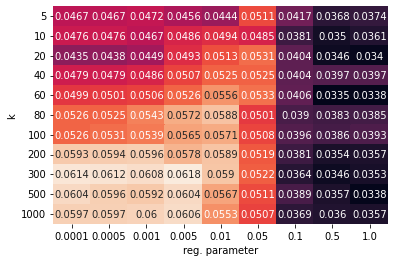

In [26]:
# n_iter = 2000 and lr = 0.001
show_plot(precision_score)

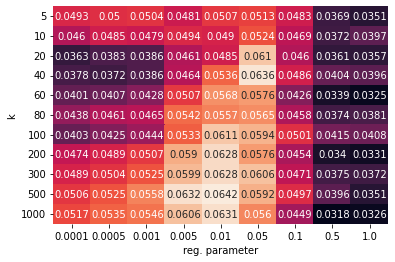

In [34]:
# n_iter = 2000 and lr = 0.005
show_plot(precision_score_1[1])

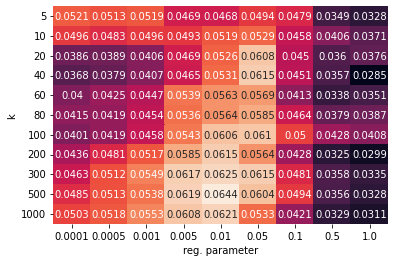

In [42]:
# n_iter = 2000 and lr = 0.01
show_plot(precision_score_2)

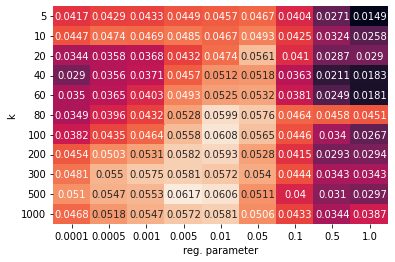

In [43]:
# n_iter = 2000 and lr = 0.05
show_plot(precision_score_3)